In [2]:
import numpy as np
from numpy import random

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

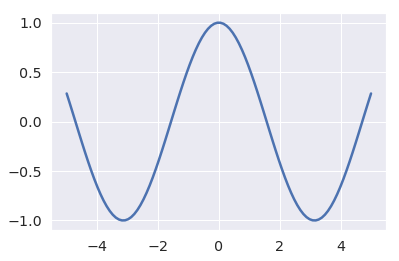

In [3]:
x = np.linspace(-5,5,100)
plt.plot(x,np.cos(x))

In [48]:
D = 50
N = 500
P = 1000

def construct_manifolds(R1,R2,D):
    # Basis vectors
    U = random.randn(N,2*D+2)
    U,_ = np.linalg.qr(U)
    U1 = U[:,:D]
    U2 = U[:,D:2*D]
    
    # Centroids
    x01 = U[:,-1] / np.sqrt(2)
    x02 = U[:,-2] / np.sqrt(2)

    # Random sample from unit sphere
    s1 = random.randn(D,P)
    s1 /= np.linalg.norm(s1,axis=0)
    s2 = random.randn(D,P)
    s2 /= np.linalg.norm(s2,axis=0)

    X1 = (x01[:,None] + R1*U1@s1).T
    X2 = (x02[:,None] + R2*U2@s2).T
    return X1, X2

In [49]:
def compute_err(X1,X2,m):
    idxs1 = random.randint(0, len(X1), [m, n_test])
    idxs2 = random.randint(0, len(X2), [m, n_test])
    x1 = X1[idxs1]
    x2 = X2[idxs2]
    y1 = X1
    y2 = X2
    w = (x1 - x2).mean(0)
    mu = (x1+x2).mean(0)/2
    h1 = w.dot(X1.T) - (w*mu).sum(-1, keepdims=True)
    h2 = w.dot(X2.T) - (w*mu).sum(-1, keepdims=True)
    err1 = (h1<0).mean()
    err2 = (h2>0).mean()
    
    return (err1 + err2)/2

In [58]:
m =5 
n_test = 1000
X1, X2 = construct_manifolds(1,1,50)
err = compute_err(X1,X2,m)

In [59]:
err

0.0

In [56]:
Rs = np.linspace(0.1,3,20)

errs = []
for R in Rs:
    X1, X2 = construct_manifolds(R,R,50)
    err = compute_err(X1,X2,m)
    errs.append(err)

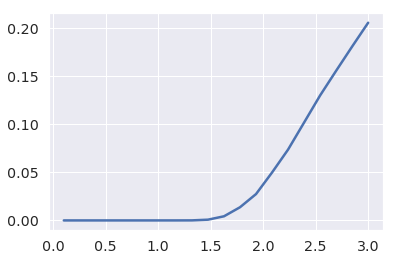

In [57]:
plt.plot(Rs,errs)